# Rice Classification
### Julian Pichler & Tobias Wecht 
Dataset: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset<br>
Splitted dataset (used in Notebook): https://drive.google.com/file/d/1fFb3Ybl2_Eq7FEYBvjThWOSdXo7wEq_v/view?usp=sharing 

Das Ziel unseres Projekts ist es Reis Bilder in die Klassen Arborio, Basmati, Ipsala, Jasmine, Karacadag zu klassifizieren. 

Es werden dabei zwei Ansätze gewählt:

*   Selber CNN aufzubauen
*   Ein pretrained Model zu finetunen


Aufgabenstellung:
Wie klein kann ein Neztwerk werden.

## Preparations

In [2]:
## this is Colab-specific; remove if you are not using Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## if using Colab, you need to run this every time you start a notebook
## on a local installation, you only need to run this once (or install the
## pyMLaux package outside of the notebook once and for all)
!pip install git+https://github.com/UBod/pyMLaux.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/UBod/pyMLaux.git to /tmp/pip-req-build-7_da8cfn
  Running command git clone -q https://github.com/UBod/pyMLaux.git /tmp/pip-req-build-7_da8cfn
  Created wheel for pyMLaux: filename=pyMLaux-0.0.5-py3-none-any.whl size=6795 sha256=1a949c89a167eaf95e65c40397ac1db0b22a92923f0b08a61bcce124b1ba8097
  Stored in directory: /tmp/pip-ephem-wheel-cache-45sg2fda/wheels/04/d3/4b/95324531ee12976752872ed3ea1a73976f19f607202f6af0c8
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=7695d8c29e2274fae188c03c989ce0dab860349bd9d4750359928b49b7451d5d
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyMLaux sklearn


In [ ]:
## remove the next line if you are not using Colab
%tensorflow_version 2.x

import os, shutil
import random
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

from pyMLaux import plot_history, evaluate_classification_result, show_img_data, evaluate_regression_result

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
## adapt this directory to your needs
base_dir = '/content/drive/MyDrive/Colab Notebooks/'
data_dir = base_dir + 'DataSets/'
data_zip = data_dir + 'rice_split.zip'

In [ ]:
## adapt this directory to your needs
base_dir = '/content/drive/MyDrive/Master/2.Semester/NDL/work/'
data_dir = base_dir + 'data/RICE/'
data_zip = data_dir + 'rice_split.zip'

In [ ]:
data_zip

'/content/drive/MyDrive/Master/2.Semester/NDL/work/data/rice_split.zip'

In [ ]:
## unzip data to local directory on Colab runtime
## (must be redone every time, since Colab kills the runtime's local memory each time)
%%capture
!cd ~; unzip -n /content/drive/MyDrive/Colab\ Notebooks/DataSets/rice_split.zip

In [ ]:
## JP setup
!cd ~; unzip -n '/content/drive/MyDrive/Master/2.Semester/NDL/work/data/RICE/rice_split.zip'

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2799).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (28).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (280).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2800).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2801).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2802).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2803).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2804).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2805).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2806).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2807).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2808).jpg  
  inflating: Rice_Image_Dataset/train/Karacadag/Karacadag (2809).jpg  
  inflating: 

In [ ]:
train_data_dir = os.path.expanduser('~/Rice_Image_Dataset/train/')
#validation_data_dir = os.path.expanduser('~/CIFAR10_processed/validation/')
test_data_dir = os.path.expanduser('~/Rice_Image_Dataset/test/')

## Configure Generators

In [ ]:
batch_size = 64
img_size = (224, 224)
train_datagen = ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   validation_split=0.15,
                                   fill_mode='constant',
                                   cval=0)
train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=img_size, 
                                                    batch_size=batch_size,
                                                    subset='training',
                                                    class_mode='sparse')
validation_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                         target_size=img_size, 
                                                         batch_size=batch_size,
                                                         subset='validation',
                                                         class_mode='sparse')
test_datagen = ImageDataGenerator(rescale=(1. / 255))
test_generator = test_datagen.flow_from_directory(test_data_dir, 
                                                  target_size=img_size, 
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='sparse')

Found 51000 images belonging to 5 classes.
Found 9000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [ ]:
all_classes = list(train_generator.class_indices.keys())
all_classes

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

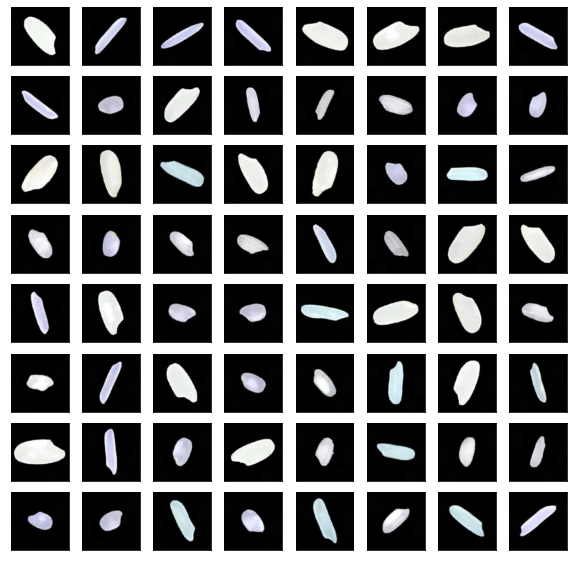

In [ ]:
for img, labels in train_generator:
    show_img_data(img, no=batch_size,layout=(8,8))
    break

# Conclusion
Es wurde mit den Anzahl der Layers, Neuronen, und Activation Funktions(relu,elu), sowie verschieden Dropout Raten(Range:0.1-0.5), Learning Raten und Optimizer probiert.

Es wurden 10 verschieden CNNs mit absteigender Anzahl an Gewichten getestet um zu zeigen, wie wenig komplex ein CNN sein kann um trotzdem noch annehmbare ACCs zu erzielen.

Alle 10 CNNs wurden mit 5 Epochen und mit einer Batch-Size von 64 trainiert.



## PRE Trained Network
Es wurde ebenfalls versucht, bereits vortrainierte Netzwerke für die Reis-Klassifizierung einzusetzten (ImageNet). Die Netzwerke auf Basis von vortrainierten Netzwerken, lieferten jedoch extrem schlechte Ergebnisse mit einer Validation Accuracy von 20-30%. Die in den vortrainieren Netzen erkannten Muster sind um einiges komplexer als die einfachen Konturen der Reiskörner.Das ist zumindest die von uns vermutete Ursache für die schlechten Ergebnisse.

# Results own CNN
### Runs:
<table>
  <tr>
    <th>Type</th>
    <th>Training ACC</th>
    <th>Validation ACC</th>
    <th>Testing Balanced ACC</th>
    <th>Anzahl Gewichte</th>
  </tr>
    <tr>
    <td>Run 1</td>
    <td>99.24</td>
    <td>99.55</td>
    <td>88.087</td>
    <td>1,327,013</td>
  </tr>
    </tr>
    <tr>
    <td>Run 2</td>
    <td>98.94</td>
    <td>99.06</td>
    <td>97.433</td>
    <td>205,548,645</td>
  </tr>
   </tr>
    </tr>
    <tr>
    <td>Run 3</td>
    <td>98.56</td>
    <td>99.27</td>
    <td>99.047</td>
    <td>205,522,917</td>
  </tr>
      </tr>
  <tr>
    <td>Run 4</td>
    <td>97.85</td>
    <td>99.31</td>
    <td>99.093</td>
    <td>51,381,317</td>
  </tr>

  </tr>
      <tr>
    <td>Run 5</td>
    <td>98.25</td>
    <td>99.01</td>
    <td>98.72</td>
    <td>25,692,069</td>
  </tr>
   </tr>
        <tr>
    <td>Run 6</td>
    <td>97.25</td>
    <td>99.38</td>
    <td>98.97</td>
    <td>12,845,565</td>
  </tr>
     </tr>
        <tr>
    <td>Run 7</td>
    <td>97.02</td>
    <td>99.32</td>
    <td>98.51</td>
    <td>4,817,270</td>
  </tr>
       </tr>
        <tr>
    <td>Run 8</td>
    <td>96.02</td>
    <td>98.17</td>
    <td>97.21</td>
    <td>1,605,952</td>
  </tr>
</tr>
          <tr>
    <td>Run 9</td>
    <td>75.19</td>
    <td>92.71</td>
    <td>87.34</td>
    <td>401,512</td>
  </tr>


  </tr>
          <tr>
    <td>Run 10</td>
    <td>58.50</td>
    <td>87.91</td>
    <td>81.74</td>
    <td>150,587</td>
  </tr>





</table>  

## Create own CNN Model

### Run 1
```
tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(48, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(48, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(96, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(96, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
```
### Run 2
```
tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
```
Die Ergebnisse von Run 2 zeigten das Run 1 schon in das Overfitting trainiert hat, das einfachere Model von Run 2 ist genereller - daher wurde die Balanced Accuracy auf die Test Daten gesteigert

### Run 3 
```
tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
```

### Run 4
Es wurde von 128 auf 32 Neuronen verringert. Dabei fällt auf das es mehr Epochen braucht um auf eine ähnliche Accuarcy zu erreichen. Das Endendergebnis ist sogar noch etwas genereller und erziehlt somit einen minimal bessere test balanced accuracy.

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #'mse',
              metrics=['accuracy']
              )

#Run 5


In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (6, 6), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #'mse',
              metrics=['accuracy']
              )

#Run 6

---



In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(8, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #'mse',
              metrics=['accuracy']
              )

#Run 7

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(3, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #'mse',
              metrics=['accuracy']
              )

#Run 8

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(1, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #'mse',
              metrics=['accuracy']
              )

#Run 9

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(1, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #'mse',
              metrics=['accuracy']
              )

#Run 10

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(1, (3, 3), input_shape=(img_size[0], img_size[1], 3),
                           padding='same', activation='relu', use_bias=False),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='relu')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #'mse',
              metrics=['accuracy']
              )

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 224, 224, 1)       27        
                                                                 
 dropout_73 (Dropout)        (None, 224, 224, 1)       0         
                                                                 
 flatten_21 (Flatten)        (None, 50176)             0         
                                                                 
 dense_49 (Dense)            (None, 3)                 150528    
                                                                 
 dropout_74 (Dropout)        (None, 3)                 0         
                                                                 
 batch_normalization_32 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                     

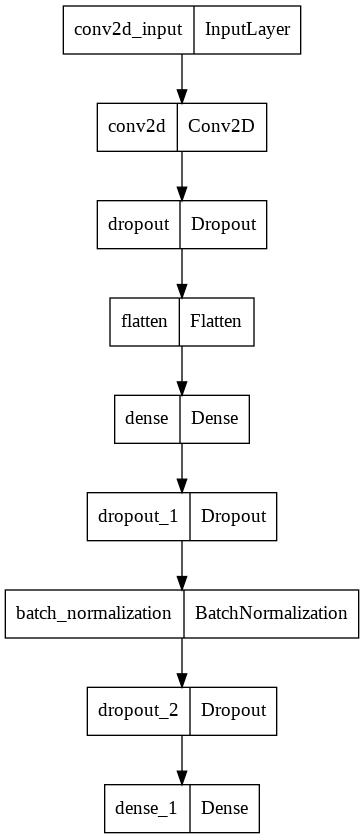

In [ ]:
plot_model(model)

### Train Model

### Model 4 wird trainiert und das beste Modell als .hdf5 File gespeichert

In [ ]:
filepath = base_dir + 'rice_{epoch:02d}-{accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
                    steps_per_epoch=(len(train_generator.filenames) // batch_size), 
                    epochs=5,#30
                    validation_data=validation_generator, 
                    validation_steps=(len(validation_generator.filenames) // batch_size),
                    callbacks=callbacks_list)
                    

#best mae seen 5.9

Epoch 1/5
796/796 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9301
Epoch 1: accuracy improved from inf to 0.93007, saving model to /content/drive/MyDrive/Master/2.Semester/NDL/work/rice_01-0.9301.hdf5
796/796 [==============================] - 654s 810ms/step - loss: 0.2445 - accuracy: 0.9301 - val_loss: 0.0395 - val_accuracy: 0.9887
Epoch 2/5
796/796 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9731
Epoch 2: accuracy did not improve from 0.93007
796/796 [==============================] - 643s 807ms/step - loss: 0.0894 - accuracy: 0.9731 - val_loss: 0.0249 - val_accuracy: 0.9932
Epoch 3/5
796/796 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9742
Epoch 3: accuracy did not improve from 0.93007
796/796 [==============================] - 638s 802ms/step - loss: 0.0810 - accuracy: 0.9742 - val_loss: 0.0219 - val_accuracy: 0.9937
Epoch 4/5
796/796 [==============================] - ETA: 0s - loss: 0.0688 - accu

##Plotten der Accuracy während des Trainings

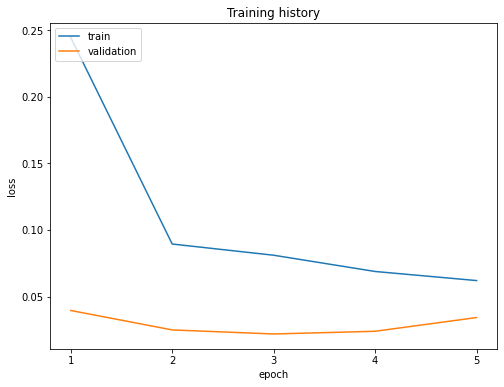

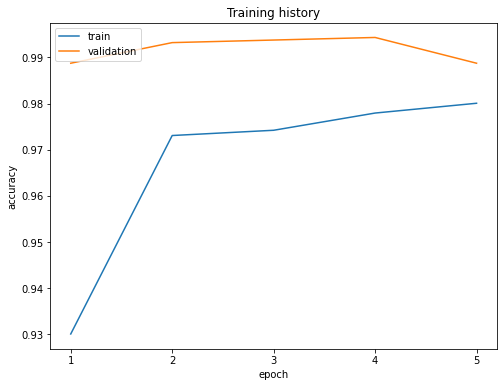

In [ ]:
plot_history(history, measure='accuracy')

### Evaluate current model on Test Data

In [ ]:
pred = model.predict(test_generator, steps=(len(test_generator.filenames)))

15000/15000 [==============================] - 28s 2ms/step


In [ ]:
evaluate_classification_result(test_generator.classes, pred, classes=all_classes);

[[2963    0    0   20   17]
 [   1 2968    0   31    0]
 [   2    0 2998    0    0]
 [   1   13    0 2986    0]
 [  51    0    0    0 2949]]


Class Arborio:
    Sensitivity (TPR):  98.767% (2963 of 3000)
    Specificity (TNR):  99.542% (11945 of 12000)
    Precision:          98.178% (2963 of 3018)
    Neg. pred. value:   99.691% (11945 of 11982)
Class Basmati:
    Sensitivity (TPR):  98.933% (2968 of 3000)
    Specificity (TNR):  99.892% (11987 of 12000)
    Precision:          99.564% (2968 of 2981)
    Neg. pred. value:   99.734% (11987 of 12019)
Class Ipsala:
    Sensitivity (TPR):  99.933% (2998 of 3000)
    Specificity (TNR): 100.000% (12000 of 12000)
    Precision:         100.000% (2998 of 2998)
    Neg. pred. value:   99.983% (12000 of 12002)
Class Jasmine:
    Sensitivity (TPR):  99.533% (2986 of 3000)
    Specificity (TNR):  99.575% (11949 of 12000)
    Precision:          98.321% (2986 of 3037)
    Neg. pred. value:   99.883% (11949 of 11963)
Class Karacadag:
    Sensitivi

## Pre-Trained Model
wurden verworfen, da accuracy nur bei 20-30% lag.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size[0], img_size[1], 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
flat = tf.keras.layers.GlobalAveragePooling2D()(base_model.layers[-1].output)
dense = tf.keras.layers.Dense(256, activation='relu')(flat)
dropout = tf.keras.layers.Dropout(0.4)(dense) 
dense2 = tf.keras.layers.Dense(256, activation='relu')(dropout)
dropout2 = tf.keras.layers.Dropout(0.4)(dense2) 
dense3 = tf.keras.layers.Dense(128, activation='relu')(dropout2)
dropout3 = tf.keras.layers.Dropout(0.3)(dense3) 
dense4 = tf.keras.layers.Dense(128, activation='relu')(dropout3)
dropout4 = tf.keras.layers.Dropout(0.3)(dense4) 
output = tf.keras.layers.Dense(1, activation=None)(dropout4)#dropout 4
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)
# model.compile(optimizer='adam',
#               loss='mse',
#               metrics=['mse', 'mae'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #'mse',
              metrics=['accuracy']
              )

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#Generator
pre_batch_size = 64
pre_img_size = (224, 224)
pre_train_datagen = ImageDataGenerator(rescale=(1. / 224),
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   validation_split=0.15,
                                   fill_mode='constant',
                                   cval=0)
pre_train_generator = pre_train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=pre_img_size, 
                                                    batch_size=pre_batch_size,
                                                    subset='training',
                                                    class_mode='sparse')
pre_validation_generator = pre_train_datagen.flow_from_directory(train_data_dir, 
                                                         target_size=pre_img_size, 
                                                         batch_size=pre_batch_size,
                                                         subset='validation',
                                                         class_mode='sparse')
pre_test_datagen = ImageDataGenerator(rescale=(1. / 224))
pre_test_generator = pre_test_datagen.flow_from_directory(test_data_dir, 
                                                  target_size=pre_img_size, 
                                                  batch_size=pre_batch_size,
                                                  shuffle=False,
                                                  class_mode='sparse')

Found 51000 images belonging to 5 classes.
Found 9000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [ ]:
#Training
# filepath = base_dir + 'Models/rice/rice_pre_{epoch:02d}-{val_mae:.4f}.hdf5'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=1,
#                                                 save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

history = model.fit(pre_train_generator,
                    steps_per_epoch=(len(pre_train_generator.filenames) // batch_size), 
                    epochs=6,
                    validation_data=pre_validation_generator, 
                    validation_steps=(len(pre_validation_generator.filenames) // batch_size))


Epoch 1/6
 34/796 [>.............................] - ETA: 8:36 - loss: nan - accuracy: 0.1985

KeyboardInterrupt: ignored

### Evaluate pretrained CNN on Test Data

In [ ]:
pred = model.predict(test_generator, steps=(len(test_generator.filenames)))

   22/15000 [..............................] - ETA: 59:33  

KeyboardInterrupt: ignored

In [ ]:
evaluate_classification_result(test_generator.classes, pred);

NameError: ignored

## Evaluate on Test Data (best model)
laden des besten Modells aus Google-Deive und anschließendes Testen auf Testdaten.


In [ ]:
model_file = '/content/drive/MyDrive/Master/2.Semester/NDL/work/rice_01-0.9301.hdf5'
model = tf.keras.models.load_model(model_file)

In [ ]:
pred = model.predict(test_generator, steps=len(test_generator.filenames))

15000/15000 [==============================] - 27s 2ms/step


In [ ]:
evaluate_classification_result(test_generator.classes, pred, classes=all_classes);

[[2852    0    0   13  135]
 [   0 2976    0   23    1]
 [   5    0 2995    0    0]
 [   6   30    0 2963    1]
 [  17    0    0    0 2983]]


Class Arborio:
    Sensitivity (TPR):  95.067% (2852 of 3000)
    Specificity (TNR):  99.767% (11972 of 12000)
    Precision:          99.028% (2852 of 2880)
    Neg. pred. value:   98.779% (11972 of 12120)
Class Basmati:
    Sensitivity (TPR):  99.200% (2976 of 3000)
    Specificity (TNR):  99.750% (11970 of 12000)
    Precision:          99.002% (2976 of 3006)
    Neg. pred. value:   99.800% (11970 of 11994)
Class Ipsala:
    Sensitivity (TPR):  99.833% (2995 of 3000)
    Specificity (TNR): 100.000% (12000 of 12000)
    Precision:         100.000% (2995 of 2995)
    Neg. pred. value:   99.958% (12000 of 12005)
Class Jasmine:
    Sensitivity (TPR):  98.767% (2963 of 3000)
    Specificity (TNR):  99.700% (11964 of 12000)
    Precision:          98.800% (2963 of 2999)
    Neg. pred. value:   99.692% (11964 of 12001)
Class Karacadag:
    Sensitivi

In [3]:
!jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/Rice.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Rice.ipynb to html
[NbConvertApp] Writing 995168 bytes to /content/drive/MyDrive/Colab Notebooks/Rice.html
